In [218]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

In [219]:
df = df_ = pd.read_csv(filepath_or_buffer="C:\\Lib\\fifa_players.csv")
df = df_.copy()

In [220]:
df = df.drop(columns=['full_name','name','birth_date','nationality'])

categorical_to_nums = {'preferred_foot'  :   {'Left'  : 0, 'Right' : 1,},
                       'body_type'  :   {'Lean'  : 0, 'Normal' : 1, 'Stocky' : 2}} 
for column, mapping in categorical_to_nums.items():
    temp_series = df[column].copy()
    null_mask = temp_series.isnull()
    temp_series.loc[~null_mask] = temp_series.loc[~null_mask].map(mapping) 
    df[column] = temp_series.fillna(-1).astype('int64')

df['positions'] = df['positions'].str.split(',').str[0]   


for column in ['height_cm','value_euro','wage_euro','release_clause_euro' ]:   
    df[column] = df.groupby('positions')[column].transform(lambda x: x.fillna(x.median()))
    
    
    
df = df.drop(columns=['national_team','national_team_position','national_jersey_number','national_rating'])


encoder = LabelEncoder()

df['positions_encoded'] = encoder.fit_transform(df['positions'])


df = df.drop(columns=['positions'])

C:\Users\redoe\AppData\Local\Temp\ipykernel_14728\4183900338.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = temp_series.fillna(-1).astype('int64')
C:\Users\redoe\AppData\Local\Temp\ipykernel_14728\4183900338.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = temp_series.fillna(-1).astype('int64')


In [221]:
X = df.drop(columns=['value_euro'])


y = df['value_euro']
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1,test_size=0.20)


age                              0.247517
height_cm                        0.010486
weight_kgs                       0.016403
overall_rating                   1.422843
potential                        0.884474
wage_euro                        0.574445
preferred_foot                   0.010207
international_reputation(1-5)    0.113147
weak_foot(1-5)                   0.034973
skill_moves(1-5)                 0.207138
body_type                        0.000000
release_clause_euro              2.502382
crossing                         0.195020
finishing                        0.198109
heading_accuracy                 0.140932
short_passing                    0.363475
volleys                          0.185438
dribbling                        0.372160
curve                            0.170835
freekick_accuracy                0.129446
long_passing                     0.216498
ball_control                     0.503062
acceleration                     0.092986
sprint_speed                     0

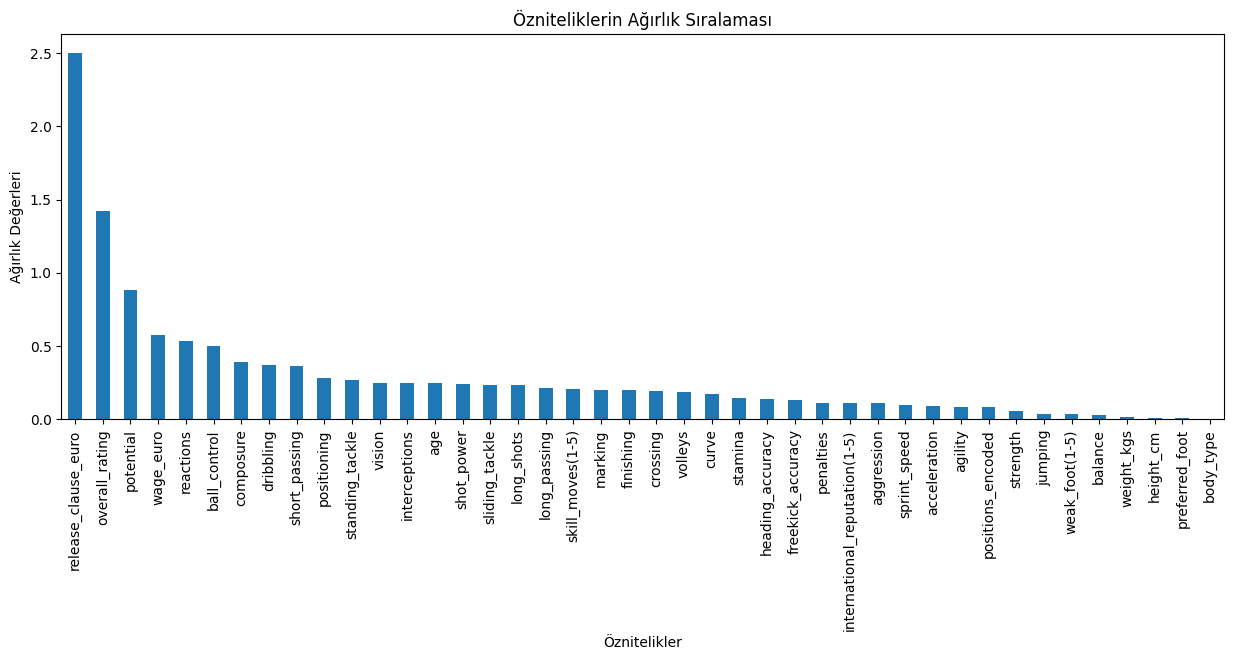

In [222]:
from sklearn.feature_selection import mutual_info_regression
mutual_info = mutual_info_regression(X,y)
mutual_info = pd.Series(mutual_info, index=X.columns)
print(mutual_info)


print(mutual_info.sort_values(ascending=False))

plt.title("Özniteliklerin Ağırlık Sıralaması")
plt.xlabel("Öznitelikler")
plt.ylabel("Ağırlık Değerleri")
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))
plt.show()

In [223]:
from sklearn.feature_selection import SelectPercentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=20)
selected_top_columns.fit(X_train,y_train)
print("------------------")
print(selected_top_columns.get_support())
print("------------------")
print(X_train.columns[selected_top_columns.get_support()])


------------------
[False False False  True  True  True False False False False False  True
 False False False  True False  True False False False  True False False
 False  True False False False False False False False False False False
 False  True False False False False]
------------------
Index(['overall_rating', 'potential', 'wage_euro', 'release_clause_euro',
       'short_passing', 'dribbling', 'ball_control', 'reactions', 'composure'],
      dtype='object')


In [224]:
# X_train'i seçilen özniteliklerle güncelleme
X_train = pd.DataFrame(selected_top_columns.transform(X_train), 
                     columns=X_train.columns[selected_top_columns.get_support()], 
                     index=X_train.index)

# X_test'i seçilen özniteliklerle güncelleme
X_test = pd.DataFrame(selected_top_columns.transform(X_test), 
                    columns=X_test.columns[selected_top_columns.get_support()], 
                    index=X_test.index)

# Kontrol için boyutları ve seçilen özellikleri yazdırma
print("Güncellenmiş veri setinin boyutu:", X_train.shape)
print("\nSeçilen öznitelikler:")
print(X_train.columns.tolist())

Güncellenmiş veri setinin boyutu: (14363, 9)

Seçilen öznitelikler:
['overall_rating', 'potential', 'wage_euro', 'release_clause_euro', 'short_passing', 'dribbling', 'ball_control', 'reactions', 'composure']


In [225]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14363 entries, 15631 to 235
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   overall_rating       14363 non-null  float64
 1   potential            14363 non-null  float64
 2   wage_euro            14363 non-null  float64
 3   release_clause_euro  14363 non-null  float64
 4   short_passing        14363 non-null  float64
 5   dribbling            14363 non-null  float64
 6   ball_control         14363 non-null  float64
 7   reactions            14363 non-null  float64
 8   composure            14363 non-null  float64
dtypes: float64(9)
memory usage: 1.1 MB


In [227]:
def shorten_number(x):
    if x >= 1_000_000_000:
        return f'{x / 1_000_000_000:.2f}B'  # Milyar
    elif x >= 1_000_000:
        return f'{x / 1_000_000:.2f}M'  # Milyon
    elif x >= 1_000:
        return f'{x / 1_000:.2f}K'  # Bin
    else:
        return str(x)

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.4182 - mean_squared_logarithmic_error: 6.4181 - val_loss: 0.1776 - val_mean_squared_logarithmic_error: 0.1779
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1678 - mean_squared_logarithmic_error: 0.1678 - val_loss: 0.1645 - val_mean_squared_logarithmic_error: 0.1647
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1494 - mean_squared_logarithmic_error: 0.1494 - val_loss: 0.1562 - val_mean_squared_logarithmic_error: 0.1564
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1323 - mean_squared_logarithmic_error: 0.1323 - val_loss: 0.1545 - val_mean_squared_logarithmic_error: 0.1547
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1332 - mean_squared_logarithmic_error: 0.1332 - val_loss: 0.1411 - val_mean_squared_logarithmic_error: 0.1412
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1218 - mean_squared_logarithmic_error: 0.1218 - val_loss: 0.1565 - val_mean_sq

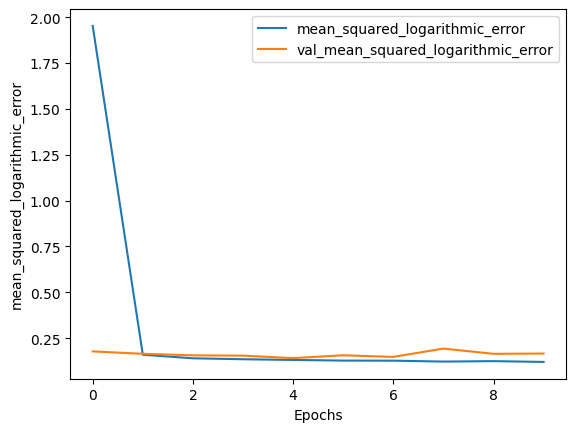

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
{'Neural Network Regression Preds': 0       1.259559e+05
1       2.637177e+06
2       5.871759e+05
3       6.862913e+05
4       6.567196e+06
            ...     
3586    8.253961e+04
3587    3.776856e+06
3588    3.735662e+07
3589    8.197411e+06
3590    1.368027e+07
Length: 3591, dtype: float32, 'Neural Network Mean Squared Error': 1445810696349.7644, 'Neural Network Root Mean Squared Error': 1202418.6859616598, 'Neural Network Mean Absolute Error': 473346.28039472597, 'Neural Network R2 Score': 0.9553220318291611, 'Neural Network Stats DF':             PREDICT        TEST     REMAINDER  REMAINDER_ABS
5132   1.259559e+05     90000.0  3.595585e+04   3.595585e+04
859    2.637177e+06   4200000.0 -1.562823e+06   1.562823e+06
10434  5.871759e+05    650000.0 -6.282406e+04   6.282406e+04
15251  6.862913e+05    950000.0 -2.637087e+05   2.637087e+05
654    6.567196e+06   6500000.0  6.719650e+04   6.719650e+04
...             ...         ...           .

In [228]:
hidden_units1 = 160
hidden_units2 = 480
hidden_units3 = 256
learning_rate = 0.01
def build_model_using_sequential():
    model = Sequential([
    Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
    ])
    return model
# build the model
model = build_model_using_sequential()
# loss function
msle = MeanSquaredLogarithmicError()
model.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate), 
    metrics=[msle]
)
# train the model
history = model.fit(
    X_train.values, 
    y_train.values, 
    epochs=10, 
    batch_size=64,
    validation_split=0.2
)
def plot_history(history, key):
    plt.plot(history.history[key])
    plt.plot(history.history['val_'+key])
    plt.xlabel("Epochs")
    plt.ylabel(key)
    plt.legend([key, 'val_'+key])
    plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')
    
neural_preds = model.predict(X_test)
neural_preds_ed = []
for i in neural_preds:
    for x in i:
        neural_preds_ed.append(x)
neural_preds_ed2 = pd.Series(neural_preds_ed)

neural_df = pd.DataFrame({'PREDICT' : neural_preds_ed, 'TEST' : y_test})
neural_df['REMAINDER'] = neural_df.apply(lambda x: x.PREDICT- x.TEST, axis=1)
neural_df['REMAINDER_ABS'] = abs(neural_df['REMAINDER'])
   
neural_mse = mean_squared_error(y_test, neural_preds_ed)
neural_rmse = math.sqrt(neural_mse)
neural_mae = mean_absolute_error(y_test, neural_preds_ed)
neural_r2 = r2_score(y_test, neural_preds_ed)
    
    
neural_values = {'Neural Network Regression Preds'          : neural_preds_ed2,
                     'Neural Network Mean Squared Error'        : neural_mse,
                     'Neural Network Root Mean Squared Error'   : neural_rmse,
                     'Neural Network Mean Absolute Error'       : neural_mae,
                     'Neural Network R2 Score'                  : neural_r2,
                     'Neural Network Stats DF'                  : neural_df}
print(neural_values)

In [229]:

print("\nEn İyi 10 Tahmin:")
print("=" * 80)
print(f"{'Index':^8} {'Gerçek Değer':^20} {'Tahmin':^20} {'Mutlak Hata':^20}")
print("-" * 80)

best_predictions = neural_df.sort_values('REMAINDER_ABS', ascending=True).head(10)
for idx, row in best_predictions.iterrows():
   print(f"{idx:^8} {shorten_number(row['TEST']):>20} {shorten_number(row['PREDICT']):>20} {shorten_number(row['REMAINDER_ABS']):>20}")

# En kötü 10 tahmin
print("\n\nEn Kötü 10 Tahmin:")
print("=" * 80)
print(f"{'Index':^8} {'Gerçek Değer':^20} {'Tahmin':^20} {'Mutlak Hata':^20}")
print("-" * 80)

worst_predictions = neural_df.sort_values('REMAINDER_ABS', ascending=False).head(10)
for idx, row in worst_predictions.iterrows():
   print(f"{idx:^8} {shorten_number(row['TEST']):>20} {shorten_number(row['PREDICT']):>20} {shorten_number(row['REMAINDER_ABS']):>20}")

# Özet istatistikler
print("\n\nÖzet İstatistikler:")
print("=" * 80)
print(f"En düşük mutlak hata: {shorten_number(best_predictions['REMAINDER_ABS'].min())}")
print(f"En yüksek mutlak hata: {shorten_number(worst_predictions['REMAINDER_ABS'].max())}")
print(f"Ortalama mutlak hata: {shorten_number(neural_df['REMAINDER_ABS'].mean())}")


En İyi 10 Tahmin:
 Index       Gerçek Değer            Tahmin            Mutlak Hata     
--------------------------------------------------------------------------------
  7083                425.00K              424.99K             14.15625
  5037                 40.00K               40.04K          41.85546875
  5115                100.00K               99.94K           60.2734375
  5262                 90.00K               89.89K          107.9609375
  9943                350.00K              350.26K            255.71875
  3291                350.00K              350.26K            259.53125
  3419                 20.00K               19.54K        459.166015625
  4080                240.00K              240.48K                482.0
  4181                240.00K              240.52K           515.109375
  5723                140.00K              140.52K               521.75


En Kötü 10 Tahmin:
 Index       Gerçek Değer            Tahmin            Mutlak Hata     
---------------


Fold 1/5
--------------------------------------------------
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 10.6610 - mean_squared_logarithmic_error: 10.6610 - val_loss: 0.3450 - val_mean_squared_logarithmic_error: 0.3442
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1258 - mean_squared_logarithmic_error: 0.1258 - val_loss: 0.2868 - val_mean_squared_logarithmic_error: 0.2861
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1192 - mean_squared_logarithmic_error: 0.1192 - val_loss: 0.2651 - val_mean_squared_logarithmic_error: 0.2645
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1169 - mean_squared_logarithmic_error: 0.1169 - val_loss: 0.2883 - val_mean_squared_logarithmic_error: 0.2876
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1136 - mean_squared_logarithmic_error: 0.1136 - val_loss: 0.2585 - val_mean_squared_logarithmic_error: 0.2580
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1150 - mean_squ

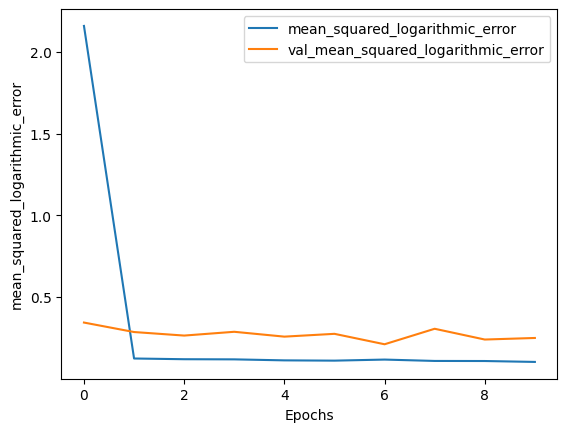


Fold 2/5
--------------------------------------------------
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.9800 - mean_squared_logarithmic_error: 2.9799 - val_loss: 0.4303 - val_mean_squared_logarithmic_error: 0.4292
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1384 - mean_squared_logarithmic_error: 0.1384 - val_loss: 0.3918 - val_mean_squared_logarithmic_error: 0.3909
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1223 - mean_squared_logarithmic_error: 0.1223 - val_loss: 0.3804 - val_mean_squared_logarithmic_error: 0.3796
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1106 - mean_squared_logarithmic_error: 0.1106 - val_loss: 0.2966 - val_mean_squared_logarithmic_error: 0.2960
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1040 - mean_squared_logarithmic_error: 0.1040 - val_loss: 0.2631 - val_mean_squared_logarithmic_error: 0.2626
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1015 - mean_squar

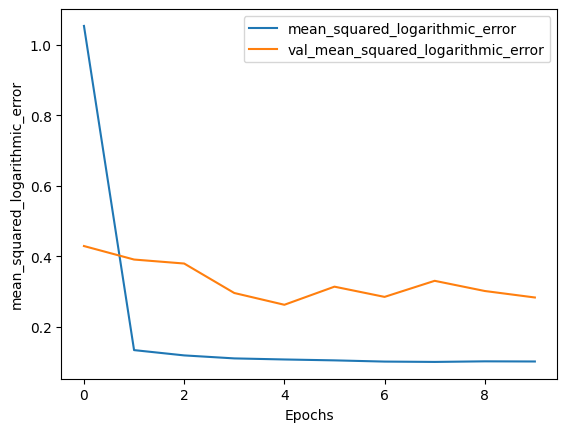


Fold 3/5
--------------------------------------------------
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.6106 - mean_squared_logarithmic_error: 8.6105 - val_loss: 0.4543 - val_mean_squared_logarithmic_error: 0.4538
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4808 - mean_squared_logarithmic_error: 0.4808 - val_loss: 0.4154 - val_mean_squared_logarithmic_error: 0.4145
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1306 - mean_squared_logarithmic_error: 0.1306 - val_loss: 0.3501 - val_mean_squared_logarithmic_error: 0.3493
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1203 - mean_squared_logarithmic_error: 0.1203 - val_loss: 0.2826 - val_mean_squared_logarithmic_error: 0.2820
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1582 - mean_squared_logarithmic_error: 0.1582 - val_loss: 0.2645 - val_mean_squared_logarithmic_error: 0.2640
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1387 - mean_squar

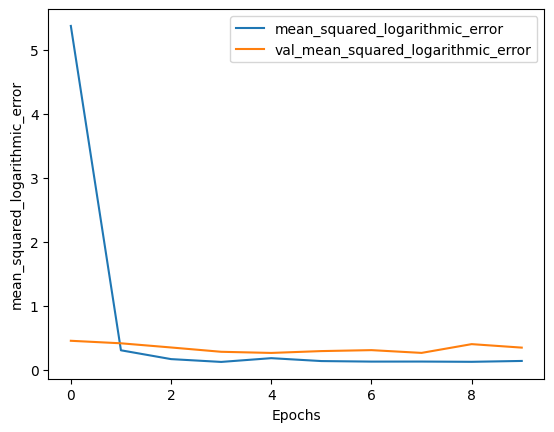


Fold 4/5
--------------------------------------------------
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 155.1357 - mean_squared_logarithmic_error: 155.1329 - val_loss: 0.3544 - val_mean_squared_logarithmic_error: 0.3536
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1378 - mean_squared_logarithmic_error: 0.1378 - val_loss: 0.3008 - val_mean_squared_logarithmic_error: 0.3001
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1328 - mean_squared_logarithmic_error: 0.1328 - val_loss: 0.2520 - val_mean_squared_logarithmic_error: 0.2514
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1261 - mean_squared_logarithmic_error: 0.1261 - val_loss: 0.2670 - val_mean_squared_logarithmic_error: 0.2664
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1083 - mean_squared_logarithmic_error: 0.1083 - val_loss: 0.2456 - val_mean_squared_logarithmic_error: 0.2451
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1172 - mean_s

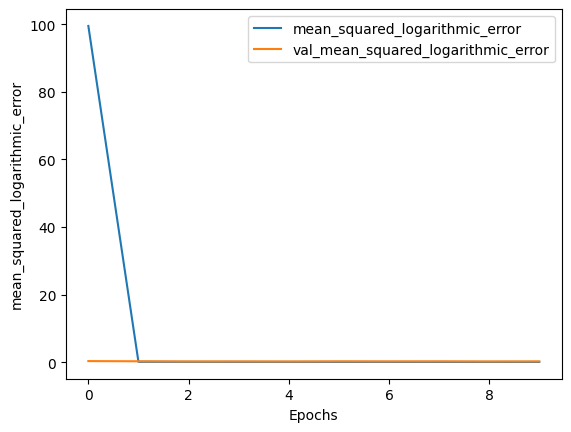


Fold 5/5
--------------------------------------------------
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.3987 - mean_squared_logarithmic_error: 8.3986 - val_loss: 3.5062 - val_mean_squared_logarithmic_error: 3.5072
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4467 - mean_squared_logarithmic_error: 2.4467 - val_loss: 0.3653 - val_mean_squared_logarithmic_error: 0.3644
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2962 - mean_squared_logarithmic_error: 0.2962 - val_loss: 0.3938 - val_mean_squared_logarithmic_error: 0.3929
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3280 - mean_squared_logarithmic_error: 0.3280 - val_loss: 0.4314 - val_mean_squared_logarithmic_error: 0.4304
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1832 - mean_squared_logarithmic_error: 0.1832 - val_loss: 0.3187 - val_mean_squared_logarithmic_error: 0.3180
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1915 - mean_squar

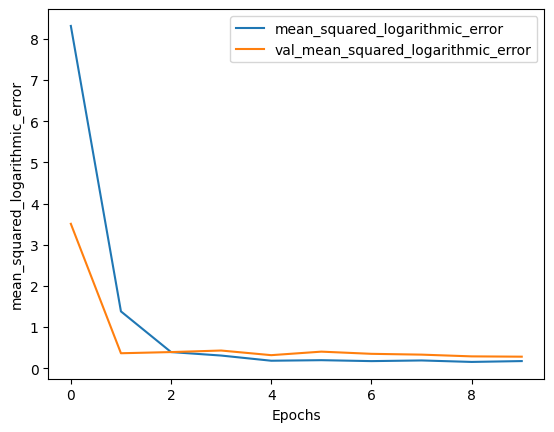


Tüm Fold'ların Ortalama Sonuçları:
--------------------------------------------------
Ortalama MSE: 1952725669365.42 (±562119015287.99)
Ortalama RMSE: 1380688.19 (±215466.48)
Ortalama MAE: 502250.80 (±87133.52)
Ortalama R2: 0.9354 (±0.0246)

En iyi fold: Fold 1
En kötü fold: Fold 2


In [230]:
from sklearn.model_selection import KFold
import numpy as np

X = df.drop(columns=['value_euro'])
y = df['value_euro']
# K-fold parametreleri
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Sonuçları saklamak için listeler
all_mse = []
all_rmse = []
all_mae = []
all_r2 = []
fold_predictions = {}

# Her fold için model eğitimi
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}/{n_splits}")
    print("-" * 50)
    
    # Train ve test verilerini ayırma
    X_train_fold = X.iloc[train_idx].values
    X_test_fold = X.iloc[test_idx].values
    y_train_fold = y.iloc[train_idx].values
    y_test_fold = y.iloc[test_idx].values
    
    # Model oluşturma
    model = build_model_using_sequential()
    
    # Model derleme
    model.compile(
        loss=msle,
        optimizer=Adam(learning_rate=learning_rate),
        metrics=[msle]
    )
    
    # Model eğitimi
    history = model.fit(
        X_train_fold,
        y_train_fold,
        epochs=10,
        batch_size=64,
        validation_split=0.2,
        verbose=1
    )
    
    # Tahminler
    neural_preds = model.predict(X_test_fold)
    neural_preds_ed = [x[0] for x in neural_preds]
    
    # Metrikleri hesaplama
    mse = mean_squared_error(y_test_fold, neural_preds_ed)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_fold, neural_preds_ed)
    r2 = r2_score(y_test_fold, neural_preds_ed)
    
    # Metrikleri listelere ekleme
    all_mse.append(mse)
    all_rmse.append(rmse)
    all_mae.append(mae)
    all_r2.append(r2)
    
    # Bu fold'un tahminlerini saklama
    fold_predictions[f'fold_{fold+1}'] = {
        'predictions': neural_preds_ed,
        'actual': y_test_fold,
        'test_indices': test_idx
    }
    
    # Bu fold'un sonuçlarını yazdırma
    print(f"\nFold {fold + 1} Sonuçları:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2: {r2:.4f}")
    
    # Öğrenme eğrisini çizme
    plot_history(history, 'mean_squared_logarithmic_error')

# Tüm fold'ların ortalama sonuçlarını yazdırma
print("\nTüm Fold'ların Ortalama Sonuçları:")
print("-" * 50)
print(f"Ortalama MSE: {np.mean(all_mse):.2f} (±{np.std(all_mse):.2f})")
print(f"Ortalama RMSE: {np.mean(all_rmse):.2f} (±{np.std(all_rmse):.2f})")
print(f"Ortalama MAE: {np.mean(all_mae):.2f} (±{np.std(all_mae):.2f})")
print(f"Ortalama R2: {np.mean(all_r2):.4f} (±{np.std(all_r2):.4f})")

# En iyi ve en kötü fold'ları belirleme
best_fold = np.argmin(all_mse)
worst_fold = np.argmax(all_mse)

print(f"\nEn iyi fold: Fold {best_fold + 1}")
print(f"En kötü fold: Fold {worst_fold + 1}")